In [1]:
import geopandas as gpd

import json
from shapely.geometry import shape, Point
import seaborn as sns
import numpy as np
import sympy as sp
import pandas as pd
from math import cos, asin, sqrt
import matplotlib.pyplot as plt
import random
import math
import sys
import copy

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Function to map tabular data to speed using distance between points
def RealSpeed(d,t):
    try:
        return float(d/t*3600.)
    except:
        return None

# Euclidean distance
def distance(lat1, lon1 ,lat2 , lon2):
    p = 0.017453292519943295     #Pi/180
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    return 12742 * asin(sqrt(a)) #2*R*asin...  

In [2]:
class MyNode:
    def __init__(self):
        self.ID_patient=None
        self.ID_node=None
        self.st_time=None
        self.serv_time=None
        self.type_serv=None
        self.in_neighbors=[]
        self.out_neighbors=[]

    def imprimir(self):
        print("Patient ID:",self.ID_patient)
        print("st time:",self.st_time)
        print("serv time:",self.serv_time)
        print("Follow:",self.in_neighbors)
        print("Coming:",self.out_neighbors)
        print("Node ID:",self.ID_node)
    
    def imprimirLineal(self):
         print(self.ID_patient,self.st_time/3600,self.serv_time/3600)

In [3]:
def FindMiddlePoints(mus,T,draw=False):
    a=np.array([(1/2.*n) for n in range(2*T+1)])
    tau=sp.symbols('tau_0:24')
    t=sp.Symbol('t')
    E=[]
    for N in range(0,T):
        if N>0 and N<T-1:
            y1=((tau[N]-tau[N-1]))/(a[2*N+1]-a[2*N-1])*(t-a[2*N-1])+tau[N-1]
            y2=((tau[N+1]-tau[N]))/(a[2*N+3]-a[2*N+1])*(t-a[2*N+1])+tau[N]
            eq1=sp.integrate(y1,(t,a[2*N],a[2*N+1]))
            eq2=sp.integrate(y2,(t,a[2*N+1],a[2*N+2]))
            e=eq1+eq2-mus[N]
            E.append(e)
            #print(e)
        elif N==0:
            y1=((tau[N]-tau[T-1]))/(a[2*N+1]-(-a[2*N+1]))*(t-(-a[2*N+1]))+tau[T-1]
            y2=((tau[N+1]-tau[N]))/(a[2*N+3]-a[2*N+1])*(t-a[2*N+1])+tau[N]
            eq1=sp.integrate(y1,(t,a[2*N],a[2*N+1]))
            eq2=sp.integrate(y2,(t,a[2*N+1],a[2*N+2]))
            e=eq1+eq2-mus[N]
            E.append(e)
            #print(e)        
        else:
            y1=((tau[N]-tau[N-1]))/(a[2*N+1]-a[2*N-1])*(t-a[2*N-1])+tau[N-1]
            y2=((tau[0]-tau[N]))/(a[2*N+1]+1-a[2*N+1])*(t-a[2*N+1])+tau[N]
            eq1=sp.integrate(y1,(t,a[2*N],a[2*N+1]))
            eq2=sp.integrate(y2,(t,a[2*N+1],a[2*N+2]))
            e=eq1+eq2-mus[N]
            E.append(e)
            #print(e)
        

    salida=sp.linsolve(E, (tau))
    #print(salida)
    results=next(iter(salida))
    
    
    if draw:
        plt.figure(figsize=(10, 5))
        plt.bar([0.5+i for i in range(T)], mus, label="Predicted hourly travel time", width=0.95, align='center',color='lightgray')
        plt.plot([0.5+i for i in range(T)],results,label="Interpolation")
        plt.xlabel('Hour')
        plt.ylabel(r'Travel Time (s)')
        plt.legend(prop={'size': 8})
        plt.savefig('./Images/Middle_points_reg.pdf')
        plt.show()
    
    results=[int(i) for i in results]
    return results

In [4]:
def FindMiddlePointsSymbol(T,draw=False):
    a=np.array([(1/2.*n) for n in range(2*T+1)])
    tau=sp.symbols(str('tau_0:')+str(T))
    t=sp.Symbol('t')
    mus=sp.symbols('u_0:24')
    E=[]
    for N in range(0,T):
        if N>0 and N<T-1:
            y1=((tau[N]-tau[N-1]))/(a[2*N+1]-a[2*N-1])*(t-a[2*N-1])+tau[N-1]
            y2=((tau[N+1]-tau[N]))/(a[2*N+3]-a[2*N+1])*(t-a[2*N+1])+tau[N]
            eq1=sp.integrate(y1,(t,a[2*N],a[2*N+1]))
            eq2=sp.integrate(y2,(t,a[2*N+1],a[2*N+2]))
            e=eq1+eq2-mus[N]
            E.append(e)
            #print(e)
        elif N==0:
            y1=((tau[N]-tau[T-1]))/(a[2*N+1]-(-a[2*N+1]))*(t-(-a[2*N+1]))+tau[T-1]
            y2=((tau[N+1]-tau[N]))/(a[2*N+3]-a[2*N+1])*(t-a[2*N+1])+tau[N]
            eq1=sp.integrate(y1,(t,a[2*N],a[2*N+1]))
            eq2=sp.integrate(y2,(t,a[2*N+1],a[2*N+2]))
            e=eq1+eq2-mus[N]
            E.append(e)
            #print(e)        
        else:
            y1=((tau[N]-tau[N-1]))/(a[2*N+1]-a[2*N-1])*(t-a[2*N-1])+tau[N-1]
            y2=((tau[0]-tau[N]))/(a[2*N+1]+1-a[2*N+1])*(t-a[2*N+1])+tau[N]
            eq1=sp.integrate(y1,(t,a[2*N],a[2*N+1]))
            eq2=sp.integrate(y2,(t,a[2*N+1],a[2*N+2]))
            e=eq1+eq2-mus[N]
            E.append(e)
            #print(e)
        

    salida=sp.linsolve(E, (tau))
    #print(salida)
    results=next(iter(salida))
    
    
    if draw:
        plt.figure(figsize=(10, 5))
        plt.bar([0.5+i for i in range(T)], mus, label="Predicted hourly travel time", width=0.95, align='center',color='lightgray')
        plt.plot([0.5+i for i in range(T)],results,label="Interpolation")
        plt.xlabel('Hour')
        plt.ylabel(r'Travel Time (s)')
        plt.legend(prop={'size': 8})
        plt.savefig('./Images/Middle_points_reg.pdf')
        plt.show()
    
    #results=[int(i) for i in results]
    return results



In [5]:
mus=FindMiddlePointsSymbol(24,False)
u=sp.symbols('u_0:24')
mus[0].subs([(u[i],10*i) for i in range(24)])

-49.7056245218898

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


33.47520000560799


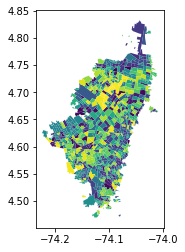

In [6]:
filename="./Input_Data/output_distances_22_8_18_1.csv"#sys.argv[1]

    
    
#~ datos1=pd.DataFrame(pd.read_csv("bogota-cadastral-2017-4-OnlyWeekdays-HourlyAggregate.csv"))
datos=pd.DataFrame(pd.read_csv("./Input_Data/bogota-cadastral-2019-3-OnlyWeekdays-HourlyAggregate.csv"))
#~ datos=pd.concat([datos1,datos2],keys=['2017-4', '2018-1'])
#print(datos)

dictDistances=pd.DataFrame(pd.read_csv(filename,header=None))
dictDistances=dictDistances.to_dict()

print(dictDistances[1][2])

data=gpd.read_file('./Input_Data/bogota_geo.json')
    
with open('./Input_Data/limites_geojson.json') as f:
	data_lims = json.load(f)   

data=data[data.scatipo.eq(0)]

data.plot(column='cartodb_id')
plt.savefig('world.pdf')


localidades=gpd.read_file('./Input_Data/Bog-poligonos-localidades.geojson')

In [7]:
posx={}
posy={}
for index, row in data.iterrows():
    try:
        posx[row['cartodb_id']],posy[row['cartodb_id']]=shape(row['geometry']).representative_point().xy[0][0],shape(row['geometry']).representative_point().xy[1][0]
    except:
        #print(row['cartodb_id'])
        pass
    #print(shape(row['geometry']).representative_point().xy[0][0],shape(row['geometry']).representative_point().xy[1][0])

TopologyException: Input geom 1 is invalid: Self-intersection at or near point -74.093562714285724 4.5682967142857134 at -74.093562714285724 4.5682967142857134
TopologyException: Input geom 1 is invalid: Self-intersection at or near point -74.093562714285724 4.5682967142857134 at -74.093562714285724 4.5682967142857134


In [8]:
# Adding new columns to the dataframe containg the travel times as read from Uber datafile.
datos["CoorXOrigen"]=datos["sourceid"].map(posx)
datos["CoorYOrigen"]=datos["sourceid"].map(posy)
datos["CoorXDestino"]=datos["dstid"].map(posx)
datos["CoorYDestino"]=datos["dstid"].map(posy)
datos=datos.dropna()

In [9]:
datos=pd.DataFrame(datos)
#print(datos.dtypes)
df=pd.DataFrame({"CoorXOrigen":datos.loc[datos.sourceid!=datos.dstid].CoorXOrigen, "CoorYOrigen":datos.loc[datos.sourceid!=datos.dstid].CoorYOrigen, \
                "CoorXDestino":datos.loc[datos.sourceid!=datos.dstid].CoorXDestino, "CoorYDestino":datos.loc[datos.sourceid!=datos.dstid].CoorYDestino,\
               "horadeldia":datos.loc[datos.sourceid!=datos.dstid].hod, "tiempo_hora":datos.loc[datos.sourceid!=datos.dstid].mean_travel_time})

"""datos=pd.DataFrame(datos)
#print(datos.dtypes)
df=pd.DataFrame({"CoorXOrigen":datos.loc[datos.sourceid!=datos.dstid].CoorXOrigen, "CoorYOrigen":datos.loc[datos.sourceid!=datos.dstid].CoorYOrigen, \
                "CoorXDestino":datos.loc[datos.sourceid!=datos.dstid].CoorXDestino, "CoorYDestino":datos.loc[datos.sourceid!=datos.dstid].CoorYDestino,\
               "horadeldia":datos.loc[datos.sourceid!=datos.dstid].hod,  , "tiempo_hora":datos.loc[datos.sourceid!=datos.dstid].mean_travel_time})"""

#df=pd.DataFrame({"CoorXOrigen":datos["CoorXOrigen"], "CoorYOrigen":datos["CoorYOrigen"], \
#                 "CoorXDestino":datos["CoorXDestino"], "CoorYDestino":datos["CoorYDestino"],\
#                "horadeldia":datos["hod"], "tiempo_hora":datos["mean_travel_time"]})

cols=["CoorXOrigen","CoorYOrigen","CoorXDestino", "CoorYDestino","horadeldia","tiempo_hora"]
df.reindex(cols)
display(df)

#df=pd.DataFrame({"CoorXOrigen":datos["CoorXOrigen"], "CoorYOrigen":datos["CoorYOrigen"], \
#                 "CoorXDestino":datos["CoorXDestino"], "CoorYDestino":datos["CoorYDestino"],\
#                "horadeldia":datos["hod"], "tiempo_hora":datos["mean_travel_time"]})

cols=["CoorXOrigen","CoorYOrigen","CoorXDestino", "CoorYDestino","horadeldia","tiempo_hora"]
df.reindex(cols)
display(df)

,CoorXOrigen,CoorYOrigen,CoorXDestino,CoorYDestino,horadeldia,tiempo_hora
0,-74.099623,4.686262,-74.087588,4.721148,10,1282.33
3,-74.033439,4.684943,-74.214904,4.625836,13,2043.50
4,-74.111644,4.677749,-74.180046,4.589392,0,514.12
5,-74.091591,4.707669,-74.211202,4.611970,0,399.07
6,-74.068389,4.692584,-74.037335,4.680848,10,1763.42
...,...,...,...,...,...,...
7060937,-74.140316,4.543767,-74.118586,4.622618,15,1285.60
7060938,-74.109216,4.592483,-74.154047,4.543817,5,1766.67
7060939,-74.135737,4.656237,-74.155440,4.678437,5,2247.38
7060941,-74.135683,4.581468,-74.084660,4.722879,18,3551.04


,CoorXOrigen,CoorYOrigen,CoorXDestino,CoorYDestino,horadeldia,tiempo_hora
0,-74.099623,4.686262,-74.087588,4.721148,10,1282.33
3,-74.033439,4.684943,-74.214904,4.625836,13,2043.50
4,-74.111644,4.677749,-74.180046,4.589392,0,514.12
5,-74.091591,4.707669,-74.211202,4.611970,0,399.07
6,-74.068389,4.692584,-74.037335,4.680848,10,1763.42
...,...,...,...,...,...,...
7060937,-74.140316,4.543767,-74.118586,4.622618,15,1285.60
7060938,-74.109216,4.592483,-74.154047,4.543817,5,1766.67
7060939,-74.135737,4.656237,-74.155440,4.678437,5,2247.38
7060941,-74.135683,4.581468,-74.084660,4.722879,18,3551.04


In [10]:

# Using inverse distances, seven neighbors and Manhattan (p=1) distances
neigh = KNeighborsRegressor(n_neighbors=7, weights="distance", p=1) 
X = df.iloc[:, :-1].values  # Input
y = df.iloc[:,5].values #outout

# Normalizing the input data
scaler = StandardScaler()  
scaler.fit(X)  

X = scaler.transform(X)  

# "training" the model

neigh.fit(X, y)


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=7, p=1,
                    weights='distance')

In [11]:
# A set of points to predict travel times during the whole day (Mandalay - Las aguas)

X_new=np.array([[-74.182690,  4.596858,-74.044301, 4.68261,   i] for i in range(24)])
X_new=scaler.transform(X_new)


#print predictions
print(neigh.predict(X_new))
#print(mus)
             
proms=neigh.predict(X_new)
#print(FindMiddlePoints(proms,24,True))

u=sp.symbols('u_0:24')
for t in range(24):
    print(mus[t].subs([(u[j],i) for i,j in zip(proms,range(24))]))


[ 694.68264382  684.57471118  713.60798607  867.39364897  860.79558555
 1192.22913552 1265.2196984  1495.90090228 1256.77587446 1201.35464937
 1136.74660164  917.70472523 1344.37328958 1136.77990075 1058.22006408
 1151.35033666 1648.09674403 2285.55067692 1756.56079671 1475.99345803
 1461.23939236 1108.52559266  873.88253654  935.69601789]
643.633724287963
691.437656951842
684.337685973449
911.400200742478
786.421798344422
1256.44188554244
1212.67024289685
1590.77390752663
1210.14585058405
1202.55802617577
1185.34322842275
779.355447875905
1480.16190599129
1094.65943307525
1046.12069952731
1094.37688182842
1598.42070275317
2499.87285393282
1686.74758903326
1432.12798552682
1528.43216204853
1087.19418107781
816.607492766946
1004.22115461406


In [12]:
Matriz=np.zeros(shape=(24,24))
vector=np.array(neigh.predict(X_new))

#print(mus)
a = sp.Poly(mus[7], u[18])
#print(a.all_coeffs()[0])
#print(mus[18])
for i in range(24):
    for j in range(24):
        a = sp.Poly(mus[i], u[j])
        #print(i,j,a.all_coeffs()[0],)
        try:
            Matriz[i,j]=a.all_coeffs()[0]
        except:
            Matriz[i,j]=0

filename="clean_Data_Tito.csv"
for size in [15,25,50,100,200]:
    for instance in range(1,6):
        Coordenadas=pd.DataFrame(pd.read_csv(filename))
        Coordenadas=Coordenadas[["lon","lat"]].sample(n=size).reset_index()
        Coordenadas["DUR"]= np.random.randint(1, 5, Coordenadas.shape[0])*15*60
        Coordenadas["SERV"]= np.random.randint(1, 2, Coordenadas.shape[0])
        Coordenadas["OPT1"]= np.random.randint(0, 20, Coordenadas.shape[0])*30*60+7*3600
        Coordenadas["OPT2"]= np.random.randint(0, 20, Coordenadas.shape[0])*30*60+7*3600
        Coordenadas["OPT3"]= np.random.randint(0, 20, Coordenadas.shape[0])*30*60+7*3600
        Coordenadas.to_csv("./Heuristicas/new_Instances/HHC_"+str(size)+"_"+str(instance)+".csv")

In [13]:
import gurobipy as gp

def RunModel(filename,constant=True,n_visits=3):
    Coordenadas=pd.DataFrame(pd.read_csv(filename))
    Coordenadas=Coordenadas[["lon","lat","DUR","SERV","OPT1","OPT2","OPT3"]]
    Coordenadas

    dict_locaciones={}
    for iter,rows in Coordenadas.iterrows():
        for iter2,rows2 in Coordenadas.iterrows():
            if iter!=iter2:
                X_new=np.array([[rows["lon"],  rows["lat"],rows2["lon"],rows2["lat"],   i] for i in range(24)])
                X_new=scaler.transform(X_new)
                proms=np.array(neigh.predict(X_new))
                dict_locaciones[iter,iter2]=Matriz.dot(proms)

    horas=[(0.5+i)*3600 for i in range(24)]
    count_nodes=0
    dict_nodes={}
    edges={}
    Patient_nodes={}

    for iter,rows in Coordenadas.iterrows():
        listnodes=[]
        for node in range(n_visits):
            col_name="OPT"+str(node+1)
            count_nodes+=1
            x = MyNode()
            x.ID_patient=iter
            x.serv_time=rows["DUR"]
            x.ID_node=count_nodes
            x.st_time=rows[col_name]
            dict_nodes[x.ID_node]=x
            listnodes.append(x.ID_node)
        Patient_nodes[iter]=listnodes

    for i in dict_nodes.keys():
        for j in dict_nodes.keys():
            if i!=j and dict_nodes[i].ID_patient!=dict_nodes[j].ID_patient:
                if constant:
                    t=np.mean(dict_locaciones[dict_nodes[i].ID_patient,dict_nodes[j].ID_patient][8:20])
                else:
                    t=np.round(np.interp(dict_nodes[i].serv_time+dict_nodes[i].st_time, horas, dict_locaciones[dict_nodes[i].ID_patient,dict_nodes[j].ID_patient]),0)
                
                if dict_nodes[i].st_time+dict_nodes[i].serv_time+t<=dict_nodes[j].st_time:
                    dict_nodes[i].out_neighbors.append(dict_nodes[j].ID_node)
                    dict_nodes[j].in_neighbors.append(dict_nodes[i].ID_node)
                    edges[i,j]=t

    for i in range(1,count_nodes):
        edges[0,i]=0
        edges[i,count_nodes+1]=0

    SortedNodes=[]
    for i in np.sort(list(dict_nodes.keys())):
        SortedNodes.append(dict_nodes[i].st_time)

    SortedNodes=np.argsort(SortedNodes)+1
    
    Model= gp.Model('netflow')
    Model.Params.timeLimit = 100.0
    x = Model.addVars(edges.keys(),  vtype=gp.GRB.BINARY, name='e')

    list_nodes=list(dict_nodes.keys())
    list_nodes+=[0,count_nodes+1]
    print(list_nodes)
    Model.addConstrs(x.sum(c,'*') == x.sum('*',c) for c in dict_nodes.keys())

    for j in Patient_nodes.keys():
        Model.addConstr(gp.quicksum([x[i,c] for i in list_nodes for c in Patient_nodes[j] if (i,c) in edges.keys()])==1)

    Model.setObjectiveN(gp.quicksum([x[0,j]  for j in dict_nodes.keys() if (0,j) in edges.keys() ]),0,2)
    Model.setObjectiveN(gp.quicksum([x[i,j]*edges[i,j]  for i in dict_nodes.keys() for j in dict_nodes.keys() if (i,j) in edges.keys() ]),1,1)

    Model.optimize()
    #Model.write("lookatme.lp")

#RunModel("./new_Instances/HHC_100_4.csv",False,3)

Using license file C:\Users\fanca\gurobi.lic
Academic license - for non-commercial use only
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 18

In [13]:
compat=np.array([[1,0,0],[1,1,0],[1,1,1]])
compat[2][2]

1

In [28]:
import gurobipy as gp

def RunModelMultiSkill(filename,constant=True,n_visits=3,nskills=1):
    print(filename)
    Coordenadas=pd.DataFrame(pd.read_csv(filename))
    Coordenadas=Coordenadas[["lon","lat","DUR","SERV","OPT1","OPT2","OPT3"]]
    #display(Coordenadas)
    dict_locaciones={}
    for iter,rows in Coordenadas.iterrows():
        for iter2,rows2 in Coordenadas.iterrows():
            if iter!=iter2:
                X_new=np.array([[rows["lon"],  rows["lat"],rows2["lon"],rows2["lat"],   i] for i in range(24)])
                X_new=scaler.transform(X_new)
                proms=np.array(neigh.predict(X_new))
                dict_locaciones[iter,iter2]=Matriz.dot(proms)

    horas=[(0.5+i)*3600 for i in range(24)]
    count_nodes=0
    dict_nodes={}
    edges={}
    Patient_nodes={}

    for iter,rows in Coordenadas.iterrows():
        listnodes=[]
        for node in range(n_visits):
            col_name="OPT"+str(node+1)
            count_nodes+=1
            x = MyNode()
            x.ID_patient=iter
            x.serv_time=rows["DUR"]
            x.type_serv=min(rows["SERV"]-1,nskills-1)
            x.ID_node=count_nodes
            x.st_time=rows[col_name]
            dict_nodes[x.ID_node]=x
            listnodes.append(x.ID_node)
        Patient_nodes[iter]=listnodes

    for i in dict_nodes.keys():
        for j in dict_nodes.keys():
            if i!=j and dict_nodes[i].ID_patient!=dict_nodes[j].ID_patient:
                if constant:
                    t=np.mean(dict_locaciones[dict_nodes[i].ID_patient,dict_nodes[j].ID_patient][6:20])
                else:
                    t=np.round(np.interp(dict_nodes[i].serv_time+dict_nodes[i].st_time, horas, dict_locaciones[dict_nodes[i].ID_patient,dict_nodes[j].ID_patient]),0)
                
                if dict_nodes[i].st_time+dict_nodes[i].serv_time+t<=dict_nodes[j].st_time:
                    dict_nodes[i].out_neighbors.append(dict_nodes[j].ID_node)
                    dict_nodes[j].in_neighbors.append(dict_nodes[i].ID_node)
                    edges[i,j]=t

    for i in range(1,count_nodes+1):
        edges[0,i]=0
        edges[i,count_nodes+1]=0

    SortedNodes=[]
    for i in np.sort(list(dict_nodes.keys())):
        SortedNodes.append(dict_nodes[i].st_time)

    SortedNodes=np.argsort(SortedNodes)+1
    
    K=range(int(nskills))
    
    ModBal = gp.Model('netflow')
    ModBal.Params.timeLimit = 3600.0
    ModBal.params.NumericFocus=2
    ModBal.params.MIPFocus=2
    ModBal.Params.OutputFlag = 0

    undic={(e[0],e[1],k):[edges[e],0] for e in edges.keys() for k in K  }
    for e in undic.keys():
        if e[1] in dict_nodes.keys():
            undic[e][1]=dict_nodes[e[1]].serv_time

    multiEdges,cost,serv=gp.multidict(undic)

    x = ModBal.addVars(multiEdges,vtype=gp.GRB.BINARY, name='e')

    #ModBal.addConstrs(gp.quicksum([x[e] for e in multiEdges if e[2]==k and e[0]==0])  == 1 for k in K)

    for j in Patient_nodes.keys():
        ModBal.addConstr(gp.quicksum([x[e] for e in multiEdges if e[1] in Patient_nodes[j] and compat[e[2],int(dict_nodes[e[1]].type_serv)]==1])==1)

    ModBal.addConstrs(x.sum(c,'*',k) == x.sum('*',c,k) for c in dict_nodes.keys() for k in K)

    #ModBal.addConstrs(gp.quicksum([x[e]*(cost[e]) for e in multiEdges if e[2]==k])  <= z_max for k in K)
    #ModBal.addConstrs(gp.quicksum([x[e]*(cost[e]+serv[e]) for e in multiEdges if e[2]==k])  >= z_min for k in K)
    #ModBal.addConstrs(gp.quicksum([x[e]*(cost[e]) for e in multiEdges if e[2]==k])  <= z for k in K)
    
    ModBal.setObjectiveN(gp.quicksum([x[e]*(e[2]+1)  for e in multiEdges if e[0]==0 ]),0,2)
   # ModBal.setObjectiveN(gp.quicksum([x[e]*(cost[e]+serv[e]) for e in multiEdges]),1,1)
    ModBal.optimize()
   # ModBal.write("lookatme.lp")
    
    nObjectives = ModBal.NumObj
    print("Solution Time:",ModBal.Runtime)
    output_Excel=[filename,constant ,n_visits ,nskills, ModBal.Runtime]
    for o in range(nObjectives):
        ModBal.params.ObjNumber = o
        output_Excel.append(ModBal.ObjNVal)
    output_Excel+=[sum([x[e].X>0.5 for e in multiEdges if e[0]==0 and e[2]==k]) for k in K]
    if nskills==1:
        output_Excel+=[0,0]
    if nskills==2:
        output_Excel+=[0]
    
    nextNode={0:[]}
    for e in multiEdges:
        if x[e].X>0.5:
            if e[0]!=0:
                nextNode[e[0]]=e[1]
            else:
                 nextNode[e[0]].append(e[1])

    Rutas=[]
    for i in nextNode[0]:
        route=[0]
        route=WriteRoute(nextNode,i,route)
        Rutas.append(route)  
    print(Rutas)
    list_cost=[]
    for ruta in Rutas:
        cost_ruta=0
        for i,j in zip(ruta, ruta[1:]):
            cost_ruta+=cost[i,j,0]+serv[i,j,0]
        list_cost.append(cost_ruta) 
    output_Excel+=[np.max(list_cost),np.min(list_cost)]
    print(output_Excel)
    return output_Excel
    #Model.write("lookatme.lp")

TablaResultados=[]
#print(RunModelMultiSkill("./new_Instances/HHC_50_1.csv",False,3,3))
for size in [100]:#[15,25,50,75]:#,
    for instance in range(1,6):
        for constant in [True,False]:
            for visit in [1,2,3]:
                for skills in [1,2,3]:
                    #break
                    filename="./new_Instances/HHC_"+str(size)+"_"+str(instance)+".csv"
                    TablaResultados.append(RunModelMultiSkill(filename,constant,visit,skills))



./new_Instances/HHC_100_1.csv
Changed value of parameter timeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter NumericFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Solution Time: 0.06199836730957031
[[0, 3, 60, 77, 23, 85, 35], [0, 4, 32, 90, 37, 38, 26], [0, 8, 5, 25, 39], [0, 9, 49, 7, 16], [0, 11, 81, 88, 17, 78, 91, 50], [0, 13, 12, 36, 1, 93, 43, 56], [0, 22, 72, 21, 51, 34], [0, 24, 40, 6, 18], [0, 27, 20, 79], [0, 33, 10, 62, 14], [0, 44, 64, 41, 89, 73], [0, 47, 96, 58, 66, 46, 92], [0, 54, 2, 67, 29], [0, 61, 15, 42, 69, 31], [0, 63, 68, 55, 52, 30, 100], [0, 65, 98, 87, 75], [0, 70, 19, 59, 86, 28], [0, 74, 82, 76, 94, 84, 95], [0, 83, 97, 80, 48], [0, 99, 57, 53, 71, 45]]
['./new_Instances/HHC_100_1.csv', True, 1, 1, 0.06199836730957031, 20.0, 20, 0, 0, 26676.600610924448, 9330.111911850598]
./new_Instances/HHC_100_1.csv
Changed value of parameter timeL

Changed value of parameter timeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter NumericFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Solution Time: 0.05800819396972656
[[0, 2, 94, 71, 79], [0, 4, 64, 65, 98, 85, 75], [0, 9, 8, 5, 23, 38, 45], [0, 11, 81, 99, 19, 80, 84, 35], [0, 13, 61, 33, 10, 51, 100, 16], [0, 24, 12, 49, 7, 30, 89], [0, 32, 27, 25, 50, 56], [0, 36, 41, 58, 93, 26], [0, 40, 1, 86, 92], [0, 42, 46, 31], [0, 44, 97, 78], [0, 54, 17, 53, 91], [0, 57, 59, 69, 28], [0, 63, 3, 82, 76, 66, 43], [0, 68, 15, 47, 96, 52, 48, 95], [0, 70, 77, 39, 34], [0, 74, 22, 55, 67, 87, 20, 73], [0, 83, 60, 6, 18], [0, 88, 72, 37, 29], [0, 90, 21, 62, 14]]
['./new_Instances/HHC_100_1.csv', False, 1, 1, 0.05800819396972656, 20.0, 20, 0, 0, 26764.0, 10655.0]
./new_Instances/HHC_100_1.csv
Changed value of parameter timeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  D

Changed value of parameter timeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter NumericFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Solution Time: 0.06399917602539062
[[0, 5, 55, 60, 31, 45], [0, 6, 69, 82, 53, 8, 27], [0, 12, 87, 97, 41, 19], [0, 23, 93, 26, 37, 14], [0, 35, 88, 1, 78, 47], [0, 42, 89, 38, 51, 4, 74], [0, 43, 90, 86, 61, 30, 44], [0, 48, 34, 32, 94, 50, 70, 76], [0, 52, 49, 67, 21, 54, 16], [0, 64, 20, 85, 10], [0, 72, 65, 73, 17, 11, 24, 28], [0, 79, 18, 68, 81, 58, 2, 36, 92], [0, 80, 22, 25, 40, 62], [0, 84, 75, 13, 63], [0, 91, 98, 96, 15, 77, 3, 7, 83], [0, 95, 46, 9, 33, 29, 57], [0, 99, 66, 71, 39, 59, 100, 56]]
['./new_Instances/HHC_100_2.csv', True, 1, 1, 0.06399917602539062, 17.0, 17, 0, 0, 31109.242727316247, 13427.574671157467]
./new_Instances/HHC_100_2.csv
Changed value of parameter timeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: 

Changed value of parameter timeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter NumericFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Solution Time: 0.04599952697753906
[[0, 5, 66, 39, 59, 100, 56, 45], [0, 12, 49, 81, 13, 31], [0, 23, 18, 68, 85, 53, 16], [0, 35, 65, 32, 67, 40, 41, 83], [0, 42, 98, 96, 17, 11, 54, 57], [0, 43, 6, 69, 1, 77, 14], [0, 48, 87, 21, 70, 47], [0, 52, 75, 15, 51, 29, 27], [0, 64, 90, 78, 76], [0, 72, 20, 94, 63], [0, 79, 34, 38, 25, 82, 36, 62], [0, 80, 46, 9, 37, 44], [0, 84, 26, 60, 7, 74], [0, 89, 73, 97, 3, 8, 19], [0, 91, 93, 22, 33, 30, 10], [0, 95, 55, 71, 58, 50, 24, 28], [0, 99, 88, 86, 61, 2, 4, 92]]
['./new_Instances/HHC_100_2.csv', False, 1, 1, 0.04599952697753906, 17.0, 17, 0, 0, 25365.0, 15753.0]
./new_Instances/HHC_100_2.csv
Changed value of parameter timeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Cha

Changed value of parameter timeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter NumericFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Solution Time: 0.04692840576171875
[[0, 13, 56, 67, 21, 96, 15], [0, 14, 55, 39, 99, 42, 7], [0, 17, 66, 50, 36], [0, 22, 76, 92], [0, 30, 20, 40, 94, 61, 9, 33], [0, 32, 2, 31, 12, 11, 4], [0, 35, 63, 34, 45, 59], [0, 38, 24, 41, 10, 1, 93, 72], [0, 43, 28, 60, 70], [0, 44, 29, 81, 57, 98, 23], [0, 47, 46, 97, 6, 51, 82], [0, 54, 8, 75, 87, 37, 49, 89], [0, 68, 90, 25, 16, 91, 88], [0, 74, 48, 65, 26, 18, 86, 27], [0, 80, 78, 64, 77, 84, 52], [0, 83, 62, 3, 19], [0, 85, 69, 100, 79, 73], [0, 95, 5, 53, 58, 71]]
['./new_Instances/HHC_100_3.csv', True, 1, 1, 0.04692840576171875, 18.0, 18, 0, 0, 28430.19224312344, 10577.029140253351]
./new_Instances/HHC_100_3.csv
Changed value of parameter timeLimit to 3600.0
   Prev: inf  Min: 0.0  M

Changed value of parameter timeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter NumericFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Solution Time: 0.046966552734375
[[0, 5, 87, 51, 86], [0, 13, 56, 22, 57, 36, 89], [0, 14, 90, 67, 34, 96, 71], [0, 20, 81, 76, 45, 93], [0, 30, 48, 55, 26, 99, 92, 33], [0, 32, 28, 41, 16, 12, 1, 88], [0, 35, 78, 31, 49, 59], [0, 38, 24, 40, 94, 11, 52], [0, 43, 85, 64, 21, 58], [0, 44, 46, 53, 42, 72], [0, 54, 17, 97, 50, 91, 19], [0, 63, 25, 6, 79, 70], [0, 65, 37, 98], [0, 68, 29, 2, 39, 10, 3, 73], [0, 69, 61, 9, 4], [0, 74, 83, 62, 77, 82, 23], [0, 80, 47, 100, 60, 15], [0, 95, 8, 75, 66, 18, 84, 27, 7]]
['./new_Instances/HHC_100_3.csv', False, 1, 1, 0.046966552734375, 18.0, 18, 0, 0, 28259.0, 10504.0]
./new_Instances/HHC_100_3.csv
Changed value of parameter timeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Ch

Changed value of parameter timeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter NumericFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Solution Time: 0.05699920654296875
[[0, 1, 38, 17, 77, 87, 73], [0, 8, 53, 95, 93, 21, 11, 64], [0, 14, 10, 3, 89, 35, 62], [0, 18, 12, 74, 25, 15, 97, 22], [0, 24, 98, 71, 55, 27], [0, 30, 82, 36, 81, 42, 45], [0, 31, 84, 4, 72], [0, 37, 50, 43, 33], [0, 44, 49, 76, 19, 92, 39], [0, 51, 63, 65, 47, 56, 20], [0, 58, 32, 88, 100], [0, 70, 83, 16, 29, 5, 94, 13], [0, 75, 46, 2, 91, 85, 6, 7], [0, 78, 54, 59, 60, 26, 80], [0, 79, 90, 57, 52, 61, 68, 23], [0, 86, 41, 48, 34, 40, 9], [0, 96, 66, 67, 28, 99, 69]]
['./new_Instances/HHC_100_4.csv', True, 1, 1, 0.05699920654296875, 17.0, 17, 0, 0, 27345.147149026478, 13625.841030688025]
./new_Instances/HHC_100_4.csv
Changed value of parameter timeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: 

Changed value of parameter timeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter NumericFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Solution Time: 0.05193138122558594
[[0, 8, 53, 16, 4, 11, 9], [0, 18, 98, 34, 91, 21], [0, 30, 82, 58, 32, 92, 13], [0, 41, 95, 93, 99, 6, 7], [0, 44, 63, 36, 59, 43, 56, 64], [0, 46, 48, 19, 40, 85, 94], [0, 49, 54, 67, 60, 26, 45], [0, 51, 24, 38, 57, 89, 20], [0, 65, 71, 88, 68, 97, 39], [0, 70, 37, 84, 55, 100, 23], [0, 75, 12, 74, 28, 35, 80], [0, 76, 81, 61, 72, 69], [0, 78, 31, 17, 47, 87], [0, 79, 14, 10, 52, 25, 73], [0, 86, 1, 66, 50, 77, 5, 15, 27], [0, 90, 2, 3, 29, 33, 22], [0, 96, 83, 42, 62]]
['./new_Instances/HHC_100_4.csv', False, 1, 1, 0.05193138122558594, 17.0, 17, 0, 0, 25820.0, 13386.0]
./new_Instances/HHC_100_4.csv
Changed value of parameter timeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Cha

Changed value of parameter timeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter NumericFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Solution Time: 0.048000335693359375
[[0, 4, 20, 95, 57, 70], [0, 10, 26, 27], [0, 14, 32, 55, 15, 98, 12], [0, 17, 76, 91, 88, 42], [0, 22, 21, 73, 7, 89], [0, 24, 25, 53, 31, 13, 51], [0, 28, 99, 35, 50, 81, 65, 83, 47], [0, 30, 49, 2], [0, 37, 33, 41, 19], [0, 46, 8, 1, 97, 75, 69], [0, 52, 6, 9, 67, 58], [0, 60, 38, 94, 36, 74, 72, 78], [0, 63, 71, 59, 11, 61, 90, 68], [0, 66, 77, 39, 23, 48, 79, 54], [0, 82, 86, 100, 43, 34], [0, 85, 80, 29, 44], [0, 87, 56, 18, 40], [0, 92, 3, 16, 93, 62, 5, 45], [0, 96, 64, 84]]
['./new_Instances/HHC_100_5.csv', True, 1, 1, 0.048000335693359375, 19.0, 19, 0, 0, 25834.018321458087, 9915.847158214734]
./new_Instances/HHC_100_5.csv
Changed value of parameter timeLimit to 3600.0
   Prev: inf  Min:

Changed value of parameter timeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter NumericFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Solution Time: 0.048915863037109375
[[0, 17, 99, 80, 62, 61, 42], [0, 21, 93, 18, 89], [0, 22, 71, 54, 47], [0, 24, 14, 30, 31, 48, 13, 83, 78], [0, 25, 96, 56, 79, 72], [0, 28, 3, 16, 41, 49, 29, 19], [0, 33, 73, 84], [0, 37, 35, 95, 9, 65, 12], [0, 46, 77, 20, 59, 43, 2], [0, 52, 86, 50, 98, 5, 27], [0, 60, 53, 81, 64, 57, 45], [0, 63, 32, 23, 88, 67, 58], [0, 66, 8, 1, 94, 75, 70], [0, 82, 10, 6, 7, 44], [0, 85, 76, 38, 36, 26, 69], [0, 87, 55, 97, 74, 90], [0, 91, 51, 68], [0, 92, 4, 39, 15, 40], [0, 100, 11, 34]]
['./new_Instances/HHC_100_5.csv', False, 1, 1, 0.048915863037109375, 19.0, 19, 0, 0, 26248.0, 5596.0]
./new_Instances/HHC_100_5.csv
Changed value of parameter timeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Defau

In [30]:
df=pd.DataFrame(np.array(TablaResultados))
df.columns=["filename","Constant","n_visits" ,"nskills", "Runtime","FO1","P1","P2","P3","Zmax","Zmin"]
df.to_csv("TablaResultados_Fase_I_100.csv")
df

,filename,Constant,n_visits,nskills,Runtime,FO1,P1,P2,P3,Zmax,Zmin
0,./new_Instances/HHC_100_1.csv,True,1,1,0.06199836730957031,20.0,20,0,0,26676.600610924448,9330.111911850598
1,./new_Instances/HHC_100_1.csv,True,1,2,0.10300064086914062,33.0,7,13,0,24940.102747591296,6666.077061403666
2,./new_Instances/HHC_100_1.csv,True,1,3,0.2049999237060547,41.0,7,5,8,25211.43182089451,8099.244071490224
3,./new_Instances/HHC_100_1.csv,True,2,1,0.3560009002685547,12.0,12,0,0,33498.690769215194,24941.818706843762
4,./new_Instances/HHC_100_1.csv,True,2,2,0.9729995727539062,21.0,5,8,0,31933.168773460275,23307.89278221255
...,...,...,...,...,...,...,...,...,...,...,...
85,./new_Instances/HHC_100_5.csv,False,2,2,5.394929885864258,20.0,4,8,0,33404.0,26855.0
86,./new_Instances/HHC_100_5.csv,False,2,3,4.379913330078125,25.0,4,3,5,33568.0,25898.0
87,./new_Instances/HHC_100_5.csv,False,3,1,1.325948715209961,11.0,11,0,0,34649.0,23385.0
88,./new_Instances/HHC_100_5.csv,False,3,2,21.81148338317871,18.0,4,7,0,33245.0,28215.0


In [15]:
import pandas as pd
res=pd.read_csv("TablaResultados.csv")
opt_basic=res[(res["Constant"]==False) & (res["n_visits"]==3) & (res["nskills"]==1)].groupby(["filename"])["FO1"].agg(min).to_dict()

In [16]:
Coordenadas=pd.DataFrame(pd.read_csv("./new_Instances/HHC_15_1.csv"))
Coordenadas=Coordenadas[["lon","lat","DUR","SERV","OPT1","OPT2","OPT3"]]
Coordenadas

,lon,lat,DUR,SERV,OPT1,OPT2,OPT3
0,-74.151374,4.603810,1800,1,50400,57600,25200
1,-74.071635,4.611416,900,3,34200,36000,46800
2,-74.071000,4.656725,900,1,59400,57600,50400
3,-74.059037,4.650061,900,2,59400,34200,37800
4,-74.077465,4.670745,900,3,37800,57600,36000
5,-74.150780,4.621167,3600,2,36000,28800,36000
6,-74.069172,4.716945,3600,1,36000,34200,27000
7,-74.145904,4.565813,2700,2,27000,46800,39600
8,-74.127386,4.682290,2700,1,46800,43200,55800
9,-74.138184,4.623661,1800,3,27000,28800,25200


In [17]:
dict_locaciones={}
for iter,rows in Coordenadas.iterrows():
    for iter2,rows2 in Coordenadas.iterrows():
        if iter!=iter2:
            X_new=np.array([[rows["lon"],  rows["lat"],rows2["lon"],rows2["lat"],   i] for i in range(24)])
            X_new=scaler.transform(X_new)
            proms=np.array(neigh.predict(X_new))
            dict_locaciones[iter,iter2]=Matriz.dot(proms)

In [82]:
horas=[(0.5+i)*3600 for i in range(24)]
count_nodes=0
dict_nodes={}
edges={}
Patient_nodes={}

for iter,rows in Coordenadas.iterrows():
    listnodes=[]
    for node in range(1):
        col_name="OPT"+str(node+1)
        count_nodes+=1
        x = MyNode()
        x.ID_patient=iter
        x.serv_time=rows["DUR"]
        x.ID_node=count_nodes
        x.st_time=rows[col_name]
        dict_nodes[x.ID_node]=x
        listnodes.append(x.ID_node)
    Patient_nodes[iter]=listnodes

for i in dict_nodes.keys():
    for j in dict_nodes.keys():
        if i!=j and dict_nodes[i].ID_patient!=dict_nodes[j].ID_patient:
            #t=np.round(np.interp(dict_nodes[i].serv_time+dict_nodes[i].st_time, horas, dict_locaciones[dict_nodes[i].ID_patient,dict_nodes[j].ID_patient]),0)
            t=np.mean(dict_locaciones[dict_nodes[i].ID_patient,dict_nodes[j].ID_patient][8:20])
            if dict_nodes[i].st_time+dict_nodes[i].serv_time+t<=dict_nodes[j].st_time:
                dict_nodes[i].out_neighbors.append(dict_nodes[j].ID_node)
                dict_nodes[j].in_neighbors.append(dict_nodes[i].ID_node)
                edges[i,j]=t

for i in range(1,count_nodes+1):
    edges[0,i]=0
    edges[i,count_nodes+1]=0
    
SortedNodes=[]
for i in np.sort(list(dict_nodes.keys())):
    SortedNodes.append(dict_nodes[i].st_time)

SortedNodes=np.argsort(SortedNodes)+1
#print(np.where(SortedNodes == 15)[0][0])

In [83]:
X=[1,6,2,4,9]
Y=[dict_nodes[i].st_time for i in X]
print(Y)
[x for _, x in sorted(zip(Y,X), key=lambda pair: pair[0])]

[50400.0, 36000.0, 34200.0, 59400.0, 46800.0]


[2, 6, 9, 1, 4]

In [84]:
import folium
import datetime

mapa = folium.Map(location=[4.60971, -74.08175], zoom_start = 11)

points = []
for iter,rows in Coordenadas.iterrows():
    points.append((rows["lat"],rows["lon"]))
    folium.Marker( (rows["lat"],rows["lon"]),popup='{0:02.0f}:{1:02.0f}'.format(*divmod(float(rows["OPT1"]/3600) * 60, 60))).add_to(mapa)
points.append(points[0])

#folium.PolyLine(points).add_to(map)



mapa

In [85]:
import gurobipy as gp
Model= gp.Model('netflow')
Model.Params.timeLimit = 100.0
x = Model.addVars(edges.keys(),  vtype=gp.GRB.BINARY, name='e')

list_nodes=list(dict_nodes.keys())
list_nodes+=[0,count_nodes+1]
print(list_nodes)
Model.addConstrs(x.sum(c,'*') == x.sum('*',c) for c in dict_nodes.keys())

for j in Patient_nodes.keys():
    Model.addConstr(gp.quicksum([x[i,c] for i in list_nodes for c in Patient_nodes[j] if (i,c) in edges.keys()])==1)


Model.setObjectiveN(gp.quicksum([x[0,j]  for j in dict_nodes.keys() if (0,j) in edges.keys() ]),0,2)
Model.setObjectiveN(gp.quicksum([x[i,j]*edges[i,j]  for i in dict_nodes.keys() for j in dict_nodes.keys() if (i,j) in edges.keys() ]),1,1)

Model.optimize()
Model.write("lookatme.lp")

Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, 16]
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 30 rows, 116 columns and 303 nonzeros
Model fingerprint: 0x9bdc6dcf
Variable types: 0 continuous, 116 integer (116 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve removed 5 rows and 5 columns
Presolve time: 0.00s
Presolved: 25 rows and 111 columns
----------------------------------------------------

In [21]:
def WriteRoute(Next,init,route):
    route.append(init)
    if Next[init] in Next.keys():
        
        return WriteRoute(Next,Next[init],route)
    else:
        return route

In [21]:
nextNode={0:[]}
for e in edges:
    if x[e].X>0.5:
        #print(e[0],e[1],x[e].X)
        if e[0]!=0:
            nextNode[e[0]]=e[1]
        else:
             nextNode[e[0]].append(e[1])

print(nextNode,len(nextNode.keys()))
Rutas=[]
for i in nextNode[0]:
    route=[0]
    route=WriteRoute(nextNode,i,route)
    Rutas.append(route)


print(Rutas)

NameError: name 'edges' is not defined

In [ ]:
nObjectives = Model.NumObj
nSolutions  = Model.SolCount

print('Problem has', nObjectives, 'objectives')
print('Gurobi found', nSolutions, 'solutions')

for o in range(nObjectives):
    # Set which objective we will query
    Model.params.ObjNumber = o
    # Query the o-th objective value
    print(' ',Model.ObjNVal, end='')

In [ ]:
#Callback - use lazy constraints to eliminate sub-tours
def BenderCuts3(model, where):
    if where == GRB.Callback.MIPSOL:
        # make a list of edges selected in the solution
        yvals = model.cbGetSolution(model._vars)
        K=model._K
        z_max=model._z_max
        cost=ModBal._cost
        selected = gp.tuplelist((i, k) for i, k in model._vars.keys() if yvals[i, k] > 0.9)

        for k in model._K:            
            X=[n[0] for n in selected if n[1]==k]
            Y=[dict_nodes[i].st_time for i in X]
            nodesChosen=[x for _, x in sorted(zip(Y,X), key=lambda pair: pair[0])]
            
            bound=0
            Factible=True
            
            for i,j in zip(nodesChosen,nodesChosen[1:]):
                if (i, j, k) not in model._edges:
                    expr2=1+gp.quicksum(model._vars[model._sorted[l], k] for l in range(np.where(model._sorted==i)[0][0]+1,np.where(model._sorted==j)[0][0]-1))
                    expr1=model._vars[i, k] + model._vars[j, k]
                    model.cbLazy( expr1<=expr2)
                    Factible=False            
                if not Factible:
                    break
            if Factible:
                for k2 in model._K:
                    model.cbLazy( gp.quicksum((model._vars[i, k2] + model._vars[j, k2]-1)*(model._cost[i,j,k2]) for i,j in zip(nodesChosen,nodesChosen[1:]) )<=z_max)
                   #model.cbLazy( gp.quicksum((model._vars[i, k2] + model._vars[j, k2]-1)*(model._cost[i,j,k2]+model._serv[i,j,k2]) for i,j in zip(nodesChosen,nodesChosen[1:]) )>=z_min)
                    #model.cbLazy( gp.quicksum((model._vars[i, k2] + model._vars[j, k2]-1)*(model._cost[i,j,k2]) for i,j in zip(nodesChosen,nodesChosen[1:]) )<=z)
            if not Factible:
                break

In [18]:
def RunModelBalance(filename,npersons,constant=False,n_visits=3):
    import gurobipy as gp
    
    print(filename)
    Coordenadas=pd.DataFrame(pd.read_csv(filename))
    Coordenadas=Coordenadas[["lon","lat","DUR","SERV","OPT1","OPT2","OPT3"]]
    #display(Coordenadas)
    dict_locaciones={}
    for iter,rows in Coordenadas.iterrows():
        for iter2,rows2 in Coordenadas.iterrows():
            if iter!=iter2:
                X_new=np.array([[rows["lon"],  rows["lat"],rows2["lon"],rows2["lat"],   i] for i in range(24)])
                X_new=scaler.transform(X_new)
                proms=np.array(neigh.predict(X_new))
                dict_locaciones[iter,iter2]=Matriz.dot(proms)

    horas=[(0.5+i)*3600 for i in range(24)]
    count_nodes=0
    dict_nodes={}
    edges={}
    Patient_nodes={}

    for iter,rows in Coordenadas.iterrows():
        listnodes=[]
        for node in range(n_visits):
            col_name="OPT"+str(node+1)
            count_nodes+=1
            x = MyNode()
            x.ID_patient=iter
            x.serv_time=rows["DUR"]
            x.ID_node=count_nodes
            x.st_time=rows[col_name]
            dict_nodes[x.ID_node]=x
            listnodes.append(x.ID_node)
        Patient_nodes[iter]=listnodes

    for i in dict_nodes.keys():
        for j in dict_nodes.keys():
            if i!=j and dict_nodes[i].ID_patient!=dict_nodes[j].ID_patient:
                if constant:
                    t=np.mean(dict_locaciones[dict_nodes[i].ID_patient,dict_nodes[j].ID_patient][6:20])
                else:
                    t=np.round(np.interp(dict_nodes[i].serv_time+dict_nodes[i].st_time, horas, dict_locaciones[dict_nodes[i].ID_patient,dict_nodes[j].ID_patient]),0)
                
                if dict_nodes[i].st_time+dict_nodes[i].serv_time+t<=dict_nodes[j].st_time:
                    dict_nodes[i].out_neighbors.append(dict_nodes[j].ID_node)
                    dict_nodes[j].in_neighbors.append(dict_nodes[i].ID_node)
                    edges[i,j]=t

    for i in range(1,count_nodes+1):
        edges[0,i]=0
        edges[i,count_nodes+1]=0

    SortedNodes=[]
    for i in np.sort(list(dict_nodes.keys())):
        SortedNodes.append(dict_nodes[i].st_time)

    SortedNodes=np.argsort(SortedNodes)+1
    
    K=range(int(npersons))#range(int(nskills))

    ModBal= gp.Model('netflow')
    ModBal.Params.timeLimit = 1800.0
    ModBal.params.NumericFocus=2
    ModBal.params.MIPFocus=2

    undic={(e[0],e[1],k):[edges[e],0] for e in edges.keys() for k in K}
    for e in undic.keys():
        if e[1] in dict_nodes.keys():
            undic[e][1]=dict_nodes[e[1]].serv_time

    multiEdges,cost,serv=gp.multidict(undic)

    x = ModBal.addVars(multiEdges,vtype=gp.GRB.BINARY, name='e')
    z=ModBal.addVars(K, name='z')
    z_max=ModBal.addVar(obj=1,name='z_max')


    ModBal.addConstrs(gp.quicksum([x[e] for e in multiEdges if e[2]==k and e[0]==0])  <= 1 for k in K)

    for j in Patient_nodes.keys():
        ModBal.addConstr(gp.quicksum([x[e] for e in multiEdges if e[1] in Patient_nodes[j]])==1)

    ModBal.addConstrs(x.sum(c,'*',k) == x.sum('*',c,k) for c in dict_nodes.keys() for k in K)



    ModBal.addConstrs(gp.quicksum([x[e]*(cost[e]+serv[e]) for e in multiEdges if e[2]==k])  == z[k] for k in K)
    ModBal.addConstrs( z_max >= z[k] for k in K)
    #ModBal.addConstrs( z[k+1] >= z[k] for k in range(len(K)-1))
    #ModBal.addConstrs(gp.quicksum([x[e]*(cost[e]+serv[e]) for e in multiEdges if e[2]==k])  >= z_min for k in K)
    #ModBal.addConstrs(gp.quicksum([x[e]*(cost[e]) for e in multiEdges if e[2]==k])  <= z for k in K)

    ModBal.optimize()
    zs=[z[k].X for k in K]
    return [filename,np.min(zs),np.max(zs),sum(zs),ModBal.Runtime]

TablaBalance=[]
for f,n in opt_basic.items():
    TablaBalance.append(RunModelBalance(f,n,constant=False))

./new_Instances/HHC_100_1.csv
Using license file C:\Users\fanca\gurobi.lic
Academic license - for non-commercial use only
Changed value of parameter timeLimit to 1800.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter NumericFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 3433 rows, 393405 columns and 1566405 nonzeros
Model fingerprint: 0x5a79a686
Variable types: 12 continuous, 393393 integer (393393 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 25 rows and 319 columns (presolve time = 5s) ...
Presolve removed 25 rows and 319 columns (presolve time = 11s) ...
Presolve removed 25 rows and 319 columns
Presolve time: 10.51s
Presolved: 3408 rows, 393086 columns, 1492680 no

     0     2 37680.0000    0  549 39914.0000 37680.0000  5.60%     - 1689s
     1     4 37689.3466    1  645 39914.0000 37680.0000  5.60%  8834 1800s

Explored 3 nodes (272709 simplex iterations) in 1808.33 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 39914 

Time limit reached
Best objective 3.991400000000e+04, best bound 3.769000000000e+04, gap 5.5720%
./new_Instances/HHC_100_2.csv
Changed value of parameter timeLimit to 1800.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter NumericFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 3433 rows, 400027 columns and 1592893 nonzeros
Model fingerprint: 0x418fd4b2
Variable types: 12 continuous, 400015 integer (400015 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range    

  254806    3.0003955e+04   6.843803e+04   0.000000e+00    540s
  255906    3.0013945e+04   8.270888e+04   0.000000e+00    545s
  257136    3.0027756e+04   2.312399e+04   0.000000e+00    550s
  258186    3.0036697e+04   3.364456e+04   0.000000e+00    555s
  259296    3.0046694e+04   6.796459e+04   0.000000e+00    560s
  260416    3.0054417e+04   6.021662e+04   0.000000e+00    565s
  261566    3.0063888e+04   3.547212e+04   0.000000e+00    570s
  262636    3.0074661e+04   4.561676e+04   0.000000e+00    575s
  263706    3.0079458e+04   4.558174e+04   0.000000e+00    580s
  264875    3.0086813e+04   6.889537e+04   0.000000e+00    585s
  265925    3.0091364e+04   9.020473e+04   0.000000e+00    590s
  267024    3.0098565e+04   5.874958e+04   0.000000e+00    595s
  268084    3.0108041e+04   7.006414e+04   0.000000e+00    600s
  269124    3.0113442e+04   1.297506e+04   0.000000e+00    605s
  270184    3.0119786e+04   7.800834e+03   0.000000e+00    610s
  271264    3.0128472e+04   2.027323e+04

  170519    2.5970783e+04   3.687125e+05   0.000000e+00    375s
  171863    2.5991995e+04   7.197475e+04   0.000000e+00    380s
  173141    2.6021968e+04   2.469108e+05   0.000000e+00    385s
  174419    2.6052975e+04   7.778448e+04   0.000000e+00    390s
  175797    2.6075328e+04   1.680659e+05   0.000000e+00    395s
  177341    2.6098584e+04   3.582527e+05   0.000000e+00    400s
  178827    2.6116624e+04   1.061815e+05   0.000000e+00    405s
  180035    2.6139048e+04   2.484760e+05   0.000000e+00    410s
  181513    2.6167197e+04   5.273244e+05   0.000000e+00    415s
  182911    2.6183367e+04   4.870077e+05   0.000000e+00    420s
  184391    2.6203105e+04   1.503081e+05   0.000000e+00    425s
  185923    2.6226624e+04   2.352659e+05   0.000000e+00    430s
  187141    2.6247824e+04   3.453629e+04   0.000000e+00    435s
  188467    2.6269961e+04   1.745201e+05   0.000000e+00    440s
  189697    2.6298075e+04   2.311332e+05   0.000000e+00    445s
  190985    2.6327607e+04   3.462832e+05

  148362    2.2831120e+04   1.847974e+05   0.000000e+00    240s
  150202    2.2862996e+04   1.638232e+06   0.000000e+00    245s
  152284    2.2898867e+04   1.128931e+05   0.000000e+00    250s
  154444    2.2953049e+04   1.474859e+05   0.000000e+00    255s
  156410    2.3001256e+04   7.632394e+05   0.000000e+00    260s
  158682    2.3043925e+04   2.885033e+05   0.000000e+00    265s
  160984    2.3108061e+04   1.529028e+06   0.000000e+00    270s
  162916    2.3179324e+04   2.429699e+05   0.000000e+00    275s
  164960    2.3222855e+04   5.650860e+05   0.000000e+00    280s
  167336    2.3294375e+04   2.389603e+05   0.000000e+00    285s
  169262    2.3372008e+04   3.313445e+05   0.000000e+00    290s
  171498    2.3451612e+04   2.677772e+05   0.000000e+00    295s
  173482    2.3487977e+04   1.347486e+06   0.000000e+00    300s
  175988    2.3580158e+04   4.132815e+05   0.000000e+00    305s
  177946    2.3642780e+04   8.238312e+05   0.000000e+00    310s
  180248    2.3732456e+04   2.959846e+05

  118542    2.7811155e+04   5.022174e+05   0.000000e+00    165s
  122023    2.8008193e+04   3.624703e+06   0.000000e+00    170s
  125910    2.8171609e+04   1.417800e+06   0.000000e+00    175s
  129554    2.8286612e+04   2.293887e+06   0.000000e+00    180s
  133146    2.8481546e+04   2.604915e+06   0.000000e+00    185s
  136960    2.8665085e+04   5.102165e+06   0.000000e+00    190s
  140323    2.8761458e+04   3.574155e+05   0.000000e+00    195s
  142966    2.8817681e+04   9.458494e+05   0.000000e+00    200s
  145827    2.8874358e+04   2.438774e+06   0.000000e+00    205s
  148302    2.8924005e+04   9.263465e+05   0.000000e+00    210s
  151170    2.8981083e+04   3.566580e+05   0.000000e+00    215s
  153412    2.9015510e+04   1.642822e+06   0.000000e+00    220s
  156575    2.9112401e+04   1.119381e+06   0.000000e+00    225s
  159302    2.9153286e+04   3.701277e+05   0.000000e+00    230s
  162402    2.9229203e+04   1.745458e+06   0.000000e+00    235s
  165043    2.9288212e+04   4.990923e+05

     0     0 10210.5248    0   77 10743.0000 10210.5248  4.96%     -    0s
     0     0 10210.5248    0   77 10743.0000 10210.5248  4.96%     -    0s
     0     2 10214.8914    0   77 10743.0000 10214.8914  4.92%     -    0s

Cutting planes:
  MIR: 2
  GUB cover: 1
  Zero half: 21

Explored 460 nodes (19860 simplex iterations) in 1.79 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 10743 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.074300000000e+04, best bound 1.074300000000e+04, gap 0.0000%
./new_Instances/HHC_15_2.csv
Changed value of parameter timeLimit to 1800.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter NumericFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 111 rows, 1717 columns and 6592 nonzeros
Model fingerprint: 0x3b1c0ae3
Variable types: 3 contin

 28446  3036 15618.1833   37   46 16286.0000 15349.8996  5.75%  24.0   63s
 29042  2740 infeasible   48      16286.0000 15365.1384  5.65%  24.1   65s
 32070  1820 infeasible   47      16286.0000 15485.7188  4.91%  24.4   70s
 36151     0 infeasible   50      16286.0000 15743.9267  3.33%  24.2   75s

Cutting planes:
  Cover: 65
  GUB cover: 1
  Zero half: 29

Explored 37058 nodes (891928 simplex iterations) in 75.73 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: 16286 16480 21034 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.628600000000e+04, best bound 1.628600000000e+04, gap 0.0000%
./new_Instances/HHC_15_5.csv
Changed value of parameter timeLimit to 1800.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter NumericFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 1

     0     0 27657.8944    0  102 30318.0000 27657.8944  8.77%     -    1s
     0     0 27657.8944    0  107 30318.0000 27657.8944  8.77%     -    2s
     0     0 27660.6362    0   98 30318.0000 27660.6362  8.76%     -    2s
     0     0 27660.6362    0   98 30318.0000 27660.6362  8.76%     -    2s
H    0     0                    30252.000000 27660.6362  8.57%     -    3s
H    0     0                    30233.000000 27683.0000  8.43%     -    3s
     0     0 27683.0000    0   88 30233.0000 27683.0000  8.43%     -    5s
     0     0 27683.0000    0  102 30233.0000 27683.0000  8.43%     -    5s
     0     0 27683.0000    0  107 30233.0000 27683.0000  8.43%     -    5s
     0     0 27683.0000    0  117 30233.0000 27683.0000  8.43%     -    5s
     0     0 27683.0000    0  117 30233.0000 27683.0000  8.43%     -    5s
     0     0 27683.0000    0   98 30233.0000 27683.0000  8.43%     -    6s
     0     0 27683.0000    0   99 30233.0000 27683.0000  8.43%     -    6s
     0     2 27685.0000  

 55086 31463 28757.3218   76   43 30233.0000 28024.4897  7.30%  71.4  495s
 55997 32033 29110.4985   37   29 30233.0000 28026.0738  7.30%  71.0  502s
 56412 32311 28522.0129   40   43 30233.0000 28026.5608  7.30%  70.8  505s
 57285 32833 28207.7837   34   70 30233.0000 28028.3537  7.29%  70.4  511s
 58102 33436 28628.8145   44   52 30233.0000 28030.4235  7.29%  70.2  517s
 58550 33655 29288.5459   57    9 30233.0000 28030.8587  7.28%  70.0  520s
 59405 34206 29222.8748   42   38 30233.0000 28032.5913  7.28%  69.6  526s
 60336 34749 28173.4716   30   55 30233.0000 28034.8890  7.27%  69.3  532s
 60778 34972 28502.7890   28   61 30233.0000 28036.0000  7.27%  69.2  535s
 61649 35515 28191.6424   35   64 30233.0000 28038.2548  7.26%  68.9  541s
 62521 36078 28378.6196   37   46 30233.0000 28039.6979  7.25%  68.6  546s
 62968 36176 30016.2628   52   51 30233.0000 28040.2259  7.25%  68.4  551s
 63141 36317 29408.6857   47   25 30233.0000 28040.6110  7.25%  68.4  555s
 63537 36564 28527.4050  

 127234 75399 28576.3363   46   54 30233.0000 28121.6680  6.98%  56.0 1056s
 128210 75977 28863.5208   48   37 30233.0000 28123.1922  6.98%  55.9 1062s
 128665 76265 29906.0499   52   18 30233.0000 28123.5392  6.98%  55.9 1065s
 129636 76892 29817.7930   69   19 30233.0000 28124.5039  6.97%  55.8 1072s
 130099 77141 28529.3518   47   36 30233.0000 28125.1101  6.97%  55.7 1075s
 131017 77771 29650.0851   44   44 30233.0000 28126.0128  6.97%  55.6 1083s
 131510 78015 29197.4656   37   33 30233.0000 28126.4433  6.97%  55.6 1086s
 131956 78325 infeasible   40      30233.0000 28126.7005  6.97%  55.5 1090s
 132963 78911 28875.1793   57   43 30233.0000 28127.6539  6.96%  55.4 1097s
 133433 79155 29793.7059   97   74 30233.0000 28127.7843  6.96%  55.4 1100s
 134407 79714 28680.9223   44   54 30233.0000 28128.7877  6.96%  55.3 1107s
 134942 79996 28339.5154   38   74 30233.0000 28129.4083  6.96%  55.3 1111s
 136010 80580 28827.3997   62   39 30233.0000 28130.2691  6.96%  55.1 1118s
 136470 8082

 191328 112679 29534.6410   68   31 30233.0000 28172.0000  6.82%  51.6 1631s
 191815 112973 28757.2724   41   36 30233.0000 28172.1768  6.82%  51.6 1635s
 192807 113573 29430.5808   53   34 30233.0000 28172.8977  6.81%  51.5 1642s
 193309 113849 28524.3208   43   50 30233.0000 28173.2125  6.81%  51.5 1645s
 194288 114449 29671.6684   48   16 30233.0000 28174.2582  6.81%  51.4 1652s
 194825 114768 28704.4752   53   54 30233.0000 28174.6625  6.81%  51.4 1656s
 195930 115411 29467.1812   44   46 30233.0000 28175.4901  6.81%  51.3 1663s
 196447 115712 30004.9391   74   40 30233.0000 28175.9020  6.80%  51.3 1666s
 197000 116024 29475.6476   73   17 30233.0000 28176.0824  6.80%  51.3 1670s
 198167 116702 28621.5681   43   52 30233.0000 28176.6995  6.80%  51.2 1677s
 198700 116988 28852.8421   76   55 30233.0000 28177.0000  6.80%  51.2 1681s
 199659 117615 29073.5789   38   29 30233.0000 28177.6039  6.80%  51.1 1688s
 200227 117921 29764.7369   46   29 30233.0000 28177.9419  6.80%  51.1 1691s

 21866  9817 21860.0000   40   79 23959.0000 21790.0000  9.05%   101  215s
 22823 10320 22335.3913   45   56 23959.0000 21792.7784  9.04%   100  221s
 23800 10870 22591.4739   42   49 23959.0000 21795.1349  9.03%   100  227s
 24208 11090 22044.4531   41   70 23959.0000 21795.9612  9.03%   100  230s
 25050 11592 22155.1054   63   64 23959.0000 21797.0000  9.02%  99.4  237s
 25529 11708 21979.0000   51   49 23959.0000 21798.4547  9.02%  98.9  241s
 26307 12346 22092.8391   85   64 23959.0000 21799.6427  9.01%  98.5  248s
 26925 12604 infeasible  265      23959.0000 21800.0000  9.01%  98.3  251s
 28056 13263 22335.5373   72   32 23959.0000 21803.0000  9.00%  97.8  257s
 28608 13518 22651.0783   40   42 23959.0000 21804.2672  8.99%  97.6  261s
 29528 14018 22039.6458   59   28 23959.0000 21807.7300  8.98%  97.1  267s
 29948 14315 22354.0000   80   49 23959.0000 21807.7300  8.98%  96.9  270s
 30885 14788 22147.0000   97   60 23959.0000 21810.2053  8.97%  96.1  276s
 31331 15072 22123.3374  

 105640 46882 22096.3773   59   71 23952.0000 21901.2495  8.56%  76.8  762s
 105832 46956 22274.0000   92   71 23952.0000 21901.2495  8.56%  76.7  765s
 106203 47108 22284.0000   68   61 23952.0000 21902.0000  8.56%  76.7  772s
 106391 47245 22669.2413  132   47 23952.0000 21902.0750  8.56%  76.7  775s
 106971 47414 22724.6816   96   51 23952.0000 21903.0000  8.55%  76.6  783s
 107172 47510 23079.0000   59   41 23952.0000 21903.0000  8.55%  76.5  787s
 107435 47572 22779.7188   83   76 23952.0000 21903.0000  8.55%  76.5  790s
 107802 47708 22292.2217   74   77 23952.0000 21903.0000  8.55%  76.4  798s
 107957 47835 22510.0000  102   75 23952.0000 21903.0000  8.55%  76.4  802s
 108217 47914 22804.3873  137   64 23952.0000 21903.4731  8.55%  76.4  806s
 109046 48256 21921.2105   41   56 23952.0000 21904.0000  8.55%  76.2  817s
 109445 48502 22719.1992  117   34 23952.0000 21904.0000  8.55%  76.3  820s
 110722 49022 infeasible   94      23952.0000 21904.7311  8.55%  76.1  826s
 112084 4955

 207870 85880 22375.9332   61   67 23952.0000 21948.4686  8.36%  68.7 1311s
 208393 85886 22126.8925   61   66 23952.0000 21949.0000  8.36%  68.7 1319s
 208445 86063 22509.4330   70   49 23952.0000 21949.0000  8.36%  68.7 1322s
 208882 86302 22557.0000  105   55 23952.0000 21949.0000  8.36%  68.6 1325s
 210389 86821 22635.1277  162   66 23952.0000 21949.0000  8.36%  68.5 1332s
 211255 87152 22248.1819   83   72 23952.0000 21950.0000  8.36%  68.5 1337s
 212370 87563 22157.0000  104   53 23952.0000 21950.0000  8.36%  68.5 1342s
 213306 87851 22651.0000  185   68 23952.0000 21950.0000  8.36%  68.4 1347s
 213989 88244 22428.8987   58   46 23952.0000 21950.2020  8.36%  68.4 1352s
 215148 88622 22900.0000   56   34 23952.0000 21951.0000  8.35%  68.3 1357s
 216300 88954 23403.0243  167   16 23952.0000 21951.1899  8.35%  68.3 1362s
 217092 89330 22383.0636  189   91 23952.0000 21951.2468  8.35%  68.3 1366s
 218082 89711 22318.0000   57   49 23952.0000 21952.0000  8.35%  68.2 1372s
 219059 9005

  RHS range        [1e+00, 1e+00]
Presolve removed 11 rows and 24 columns
Presolve time: 0.09s
Presolved: 248 rows, 6949 columns, 25341 nonzeros
Variable types: 0 continuous, 6949 integer (6945 binary)
Presolved: 248 rows, 6949 columns, 25341 nonzeros


Root relaxation: objective 3.115618e+04, 4509 iterations, 0.21 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 31156.1818    0   89          - 31156.1818      -     -    0s
H    0     0                    33976.000000 31156.1818  8.30%     -    0s
H    0     0                    33560.000000 31235.0000  6.93%     -    0s
     0     0 31249.6498    0   99 33560.0000 31249.6498  6.88%     -    0s
     0     0 31249.6498    0   92 33560.0000 31249.6498  6.88%     -    1s
H    0     0                    32734.000000 31249.6498  4.53%     -    1s
     0     0 31249.6498    0   37 32734.0000 31249.6498  4.53%     -    1

  2051  1181 28966.5975   23  264 30471.0000 28828.0000  5.39%   365  391s
  2064  1185 28964.3634   24  262 30471.0000 28828.0000  5.39%   367  397s
  2072  1186 28924.9487   26  277 30471.0000 28828.0000  5.39%   367  401s
  2088  1191 28966.0000   28  276 30471.0000 28828.0000  5.39%   369  408s
  2097  1190 29021.5725   29  256 30471.0000 28828.0000  5.39%   369  411s
  2106  1192 29139.3768   30  251 30471.0000 28828.0000  5.39%   369  415s
  2127  1197 29229.5315   33  236 30471.0000 28828.0000  5.39%   371  430s
  2136  1199 29031.2803   35  273 30471.0000 28828.0000  5.39%   373  437s
  2146  1202 29043.7034   37  281 30471.0000 28828.0000  5.39%   376  441s
  2160  1206 29045.8430   39  275 30471.0000 28828.0000  5.39%   376  446s
  2172  1211 29053.2773   40  283 30471.0000 28828.0000  5.39%   378  452s
  2185  1213 29058.6720   42  281 30471.0000 28828.0000  5.39%   380  456s
  2198  1218 29059.2333   44  273 30471.0000 28828.0000  5.39%   381  461s
  2214  1220 29061.2768  

     0     0 30830.0948    0  247 32381.0000 30830.0948  4.79%     -   87s
     0     0 30830.0948    0  241 32381.0000 30830.0948  4.79%     -   87s
     0     0 30830.0948    0  225 32381.0000 30830.0948  4.79%     -   93s
     0     0 30830.0948    0  242 32381.0000 30830.0948  4.79%     -   94s
     0     0 30830.0948    0  221 32381.0000 30830.0948  4.79%     -  108s
     0     2 30841.0000    0  221 32381.0000 30841.0000  4.76%     -  118s
     1     3 30859.3638    1  263 32381.0000 30841.0000  4.76%  1643  124s
     3     4 30860.0000    2  246 32381.0000 30841.0000  4.76%   951  127s
     5     8 30868.2623    3  255 32381.0000 30841.0000  4.76%   902  131s
    13     8 30880.6428    4  253 32381.0000 30841.0000  4.76%   692  136s
    17    12 30874.0000    5  247 32381.0000 30864.0000  4.68%   919  144s
    21    13 30882.3532    6  248 32381.0000 30864.0000  4.68%  1513  146s
    30    17 30883.0000    7  243 32381.0000 30864.0000  4.68%  1255  153s
    36    18 30883.0000  

  4405  2534 31025.0360   58  197 32354.0000 30869.0000  4.59%   378  946s
  4430  2540 30956.0000   61  234 32354.0000 30869.0000  4.59%   380  954s
  4457  2540 30956.1795   64  245 32354.0000 30869.0000  4.59%   381  963s
  4486  2544 30961.0000   67  239 32354.0000 30869.0000  4.59%   382  972s
  4512  2548 30964.3165   70  258 32354.0000 30869.0000  4.59%   383  981s
  4540  2551 30966.3162   73  252 32354.0000 30869.0000  4.59%   385  991s
  4571  2555 31005.6986   76  259 32354.0000 30869.0000  4.59%   386 1002s
  4604  2559 30980.7298   80  232 32354.0000 30869.0000  4.59%   388 1014s
  4637  2567 30985.0000   83  223 32354.0000 30869.0000  4.59%   390 1025s
  4676  2573 30995.7215   88  218 32354.0000 30869.0000  4.59%   391 1037s
  4716  2579 30999.6023   92  228 32354.0000 30869.0000  4.59%   393 1049s
  4757  2581 31004.1766   96  240 32354.0000 30869.0000  4.59%   394 1061s
  4796  2586 31009.5317  101  227 32354.0000 30869.0000  4.59%   396 1073s
  4840  2588 31124.4129  

   194    66 27134.7080   26  262 27625.0000 27003.0000  2.25%  1116  316s
   206    66 27161.2796   28  237 27625.0000 27003.0000  2.25%  1089  321s
   222    67 27089.1324   30  221 27625.0000 27003.0000  2.25%  1061  327s
   229    68 27093.7440   32  188 27625.0000 27003.0000  2.25%  1044  330s
   242    71 27298.0515   34  185 27625.0000 27003.0000  2.25%  1044  337s
   262    72 27110.2704   38  195 27625.0000 27003.0000  2.25%  1006  343s
   273    71 27111.0000   40  197 27625.0000 27003.0000  2.25%   989  346s
   293    72 27114.3593   43  196 27625.0000 27003.0000  2.25%   964  353s
   306    74 27116.8278   45  199 27625.0000 27003.0000  2.25%   951  356s
   318    78 27117.0000   47  207 27625.0000 27003.0000  2.25%   942  361s
   331    82 27227.5429   48  182 27625.0000 27003.0000  2.25%   930  365s
   357    96 27119.0000   52  199 27625.0000 27003.0000  2.25%   913  374s
   375   102 27122.6538   55  234 27625.0000 27003.0000  2.25%   888  378s
   391   108 27184.8310  

     0     2 35752.0000    0  231          - 35752.0000      -     -   37s
     1     2 35769.3117    1  260          - 35757.9611      -  2117   41s
     5     4 35790.4096    3  254          - 35770.0000      -  1560   47s
     9     8 35791.0000    4  259          - 35779.0000      -  1481   50s
    25    13 35857.2587    7  240          - 35779.0000      -  1126   59s
    30    17 35814.0000    8  244          - 35779.0000      -  1217   62s
    40    21 35819.0000   10  248          - 35779.0000      -  1169   67s
    51    25 35836.4135   11  262          - 35779.0000      -  1234   73s
    56    32 35835.4905   12  260          - 35779.0000      -  1225   75s
    73    37 35864.0611   16  252          - 35779.0000      -  1093   81s
    87    46 35854.0000   19  192          - 35779.0000      -  1046   85s
   104    56 35884.0000   21  213          - 35779.0000      -  1028   91s
   122    73 35931.9595   23  192          - 35779.0000      -   971   95s
   154    97 35943.0000  

  6149  1720 36111.0438   66  164 36448.0000 35855.0000  1.63%   301  987s
  6328  1719 36406.0000  185  231 36448.0000 35855.0000  1.63%   301 1001s
  6330  1720 36377.0000  326  245 36448.0000 35855.0000  1.63%   301 1010s
  6332  1722 36269.0000  136  262 36448.0000 35855.0000  1.63%   301 1015s
  6333  1722 36030.0000   88  264 36448.0000 35855.0000  1.63%   301 1023s
  6334  1723 36243.0000   89  262 36448.0000 35855.0000  1.63%   301 1028s
  6336  1724 36226.0000   81  255 36448.0000 35855.0000  1.63%   300 1043s
  6337  1726 35855.0000   26  293 36448.0000 35855.0000  1.63%   250 1054s
  6339  1727 35855.0000   27  294 36448.0000 35855.0000  1.63%   251 1064s
  6341  1727 35855.0000   28  297 36448.0000 35855.0000  1.63%   251 1075s
  6345  1729 35855.0000   29  284 36448.0000 35855.0000  1.63%   251 1085s
  6349  1728 35855.0000   30  298 36448.0000 35855.0000  1.63%   251 1094s
  6353  1728 35855.0000   30  250 36448.0000 35855.0000  1.63%   252 1103s
  6357  1729 35855.0000  

     0     0 39230.0000    0  292 40600.0000 39230.0000  3.37%     -   69s
     0     0 39230.0000    0  290 40600.0000 39230.0000  3.37%     -   69s
     0     0 39230.0000    0  122 40600.0000 39230.0000  3.37%     -   73s
     0     0 39230.0000    0  124 40600.0000 39230.0000  3.37%     -   85s
     0     0 39230.0000    0  124 40600.0000 39230.0000  3.37%     -   88s
     0     2 39230.0000    0  124 40600.0000 39230.0000  3.37%     -   99s
     1     3 39273.6750    1  252 40600.0000 39230.0000  3.37% 17555  108s
     3     4 39274.0000    2  277 40600.0000 39238.0000  3.35%  6229  110s
     5     4 39285.3062    3  290 40600.0000 39238.0000  3.35%  4307  115s
    13     8 39297.0000    5  298 40600.0000 39259.0000  3.30%  2016  121s
    21     9 39328.0000    7  275 40600.0000 39259.0000  3.30%  1482  125s
    26    12 39364.0095    8  251 40600.0000 39267.0000  3.28%  1556  130s
    41    20 39334.8853   12  266 40600.0000 39267.0000  3.28%  1330  136s
    54    25 39341.0000  

  3478  1260 39654.0000  387  201 40600.0000 39282.0000  3.25%   481 1021s
  3611  1298 39916.7305  406  193 40600.0000 39282.0000  3.25%   481 1041s
  3784  1296 39678.0956  423  221 40600.0000 39282.0000  3.25%   472 1060s
  3940  1250 39686.0000  440  213 40600.0000 39282.0000  3.25%   465 1085s
  3948  1322 39687.4948  441  211 40600.0000 39282.0000  3.25%   465 1105s
  4072  1320 39709.5621  464  209 40600.0000 39282.0000  3.25%   464 1125s
  4188  1326 39732.0000  487  207 40600.0000 39282.0000  3.25%   465 1145s
  4268  1346 39744.0000  507  225 40600.0000 39282.0000  3.25%   467 1168s
  4355  1367 39752.0000  527  221 40600.0000 39282.0000  3.25%   469 1192s
  4449  1387 39767.2228  549  226 40600.0000 39282.0000  3.25%   469 1216s
  4556  1409 39775.0000  575  201 40600.0000 39282.0000  3.25%   469 1241s
  4670  1426 39918.0000  607  215 40600.0000 39282.0000  3.25%   468 1267s
  4791  1523 39957.0000  642  186 40600.0000 39282.0000  3.25%   467 1296s
  4991  1628 40033.0016  

Coefficient statistics:
  Matrix range     [1e+00, 7e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 61 rows and 2000 columns
Presolve time: 4.17s
Presolved: 1838 rows, 162129 columns, 612788 nonzeros
Variable types: 0 continuous, 162129 integer (162120 binary)
Presolved: 1838 rows, 162129 columns, 612788 nonzeros


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.657969e+02   0.000000e+00      6s
    7502    9.7831896e-01   2.457521e+06   0.000000e+00     10s
   19217    2.2639283e+04   1.946448e+05   0.000000e+00     15s
   28454    2.5412030e+04   1.163271e+06   0.000000e+00     20s
   37822    2.9243830e+04   2.468143e+05   0.000000e+00     25s
   46293    3.4604074e+04   1.314665e+06   0.000000e+00     30s
   53770    3.6836677e+04   8.794402e+05   0.000000e+00     35s
   61636    3.9484935e+04   2.098475e+06   0.000000e+00     40s
   69502 

H    0     0                    26927.000000 23520.2044  12.7%     -  360s
     0     0 23520.2044    0  383 26927.0000 23520.2044  12.7%     -  377s
H    0     0                    26275.000000 23520.2044  10.5%     -  381s
     0     0 23549.6867    0  344 26275.0000 23549.6867  10.4%     -  400s
     0     0 23549.6867    0  337 26275.0000 23549.6867  10.4%     -  420s
     0     0 23549.6867    0  343 26275.0000 23549.6867  10.4%     -  568s
     0     0 23579.2288    0  388 26275.0000 23579.2288  10.3%     -  591s
     0     0 23604.0176    0  394 26275.0000 23604.0176  10.2%     -  596s
     0     0 23614.7321    0  400 26275.0000 23614.7321  10.1%     -  614s
     0     0 23615.0000    0  317 26275.0000 23615.0000  10.1%     -  713s
     0     0 23615.0000    0  317 26275.0000 23615.0000  10.1%     -  727s
     0     2 23615.0000    0  317 26275.0000 23615.0000  10.1%     -  793s
     1     5 23648.8303    1  377 26275.0000 23615.0000  10.1%  2502  835s
     3     5 23686.3539  

Best objective 1.959500000000e+04, best bound 1.806800000000e+04, gap 7.7928%
./new_Instances/HHC_75_5.csv
Changed value of parameter timeLimit to 1800.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter NumericFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 2127 rows, 183934 columns and 731223 nonzeros
Model fingerprint: 0x18a898e8
Variable types: 10 continuous, 183924 integer (183924 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 30 rows and 571 columns
Presolve time: 3.42s
Presolved: 2097 rows, 183363 columns, 682238 nonzeros
Variable types: 0 continuous, 183363 integer (183353 binary)
Presolved: 2097 rows, 183363 columns, 682238 nonzeros


Root simplex log...

Iterat

In [19]:
pd.DataFrame(np.array(TablaBalance)).to_csv("TablaBalance.csv")

In [79]:
import seaborn as sns
sns.set()

In [93]:
df=pd.read_csv("TablaResultados.csv")
df["Patients"]=df["filename"].str.replace("./new_Instances/HHC_"," ").str.replace(".csv","")
df["Patients"]=df["Patients"].str.split("_", expand = True)
df["Patients"]=df["Patients"].apply(lambda x: int(x))
df["TotPerPatient"]=df["FO2"]/df["Patients"]
df["CostPerPatient"]=df["FO1"]/df["Patients"]*50


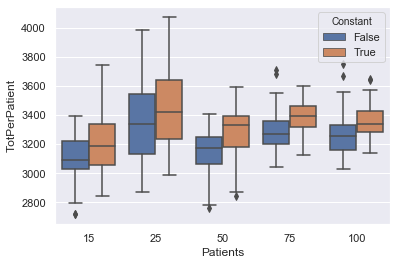

In [94]:
sns.boxplot(x="Patients",y="TotPerPatient",hue="Constant",data=df)

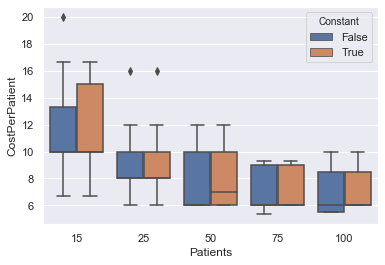

In [98]:
sns.boxplot(x="Patients",y="CostPerPatient",hue="Constant",data=df[df["nskills"]==1])

In [165]:
df["filename"].str.replace("./new_Instances/HHC_"," ").spl


0        15_1.csv
1        15_1.csv
2        15_1.csv
3        15_1.csv
4        15_1.csv
          ...    
445     100_5.csv
446     100_5.csv
447     100_5.csv
448     100_5.csv
449     100_5.csv
Name: filename, Length: 450, dtype: object

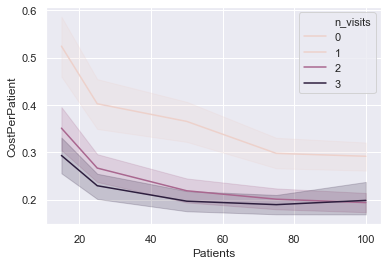

In [84]:
sns.lineplot(x="Patients",y="CostPerPatient",hue="n_visits",data=df)

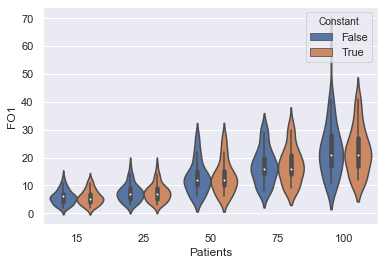

In [96]:
sns.violinplot(x="Patients",y="FO1",hue="Constant",data=df)

In [88]:
sns.boxplot(x="Patients",y="TotalTime",hue="Constant",data=df)

ValueError: Could not interpret input 'TotalTime'

In [99]:
Dimensioning=pd.concat([pd.DataFrame(pd.read_csv("TablaResultados_Fase_I.csv")),pd.DataFrame(pd.read_csv("TablaResultados_Fase_I_100.csv"))])

In [100]:
Dimensioning["Patients"]=Dimensioning["filename"].str.replace("./new_Instances/HHC_"," ").str.replace(".csv","")
Dimensioning["Patients"]=Dimensioning["Patients"].str.split("_", expand = True)
Dimensioning["Patients"]=Dimensioning["Patients"].apply(lambda x: int(x))

In [135]:
new=Dimensioning[["Patients","Constant","n_visits","nskills","Runtime","Zmax","Zmin","FO1"]]
new["Zmax/Zmin"]=new["Zmax"]/new["Zmin"]
new["FO1/Patients"]=new["FO1"]/new["Patients"]*50
new["Constant"]=new["Constant"].apply(lambda x: "Constant" if x else "Varying")
new=new.rename(columns={"Constant": "Travel Time"})

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [147]:
pd.DataFrame(new[new.Runtime<3500].pivot_table(index=['Patients',"n_visits"], columns='nskills', values='Runtime',aggfunc=np.mean)).round(2)#.to_latex("Tab1.tex",multicolumn = True, multirow = True)

nskills               1       2       3
Patients n_visits                      
15       1         0.01    0.01    0.01
         2         0.02    0.06    0.13
         3         0.05    0.12    0.32
25       1         0.01    0.01    0.02
         2         0.04    0.07    0.16
         3         0.07    0.38    1.03
50       1         0.02    0.03    0.05
         2         0.08    0.44    1.29
         3         0.20    0.64    4.63
75       1         0.03    0.06    0.11
         2         0.21    1.06    5.14
         3         0.52  292.19    7.57
100      1         0.05    0.11    0.22
         2         0.43    2.50   35.76
         3         1.31  126.20  281.49

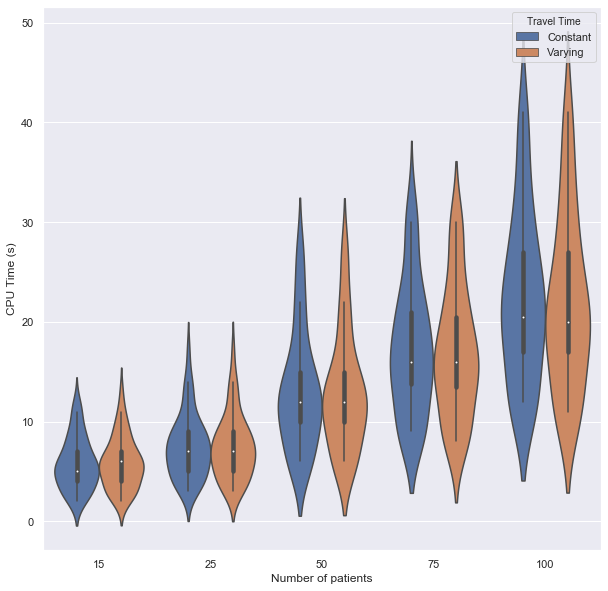

In [152]:
plt.figure(figsize=(10,10))
ax =sns.violinplot(x="Patients",y="FO1",hue="Travel Time",data=new[new.Runtime<3000])
ax.set(xlabel='Number of patients', ylabel='CPU Time (s)')
plt.savefig("myfig.png")

In [165]:
new=Dimensioning[["Patients","Constant","n_visits","nskills","Runtime","Zmax","Zmin","FO1"]]
new["Zmax/Zmin"]=new["Zmax"]/new["Zmin"]
new["FO1/Patients"]=new["FO1"]/new["Patients"]*50
new["Constant"]=new["Constant"].apply(lambda x: "Constant" if x else "Varying")
new=new.rename(columns={"Constant": "Travel Time"})
pd.DataFrame(new.pivot_table(index=['Patients',"n_visits"], columns='Travel Time', values='FO1',aggfunc=np.mean)).round(2)#.to_latex("Tab2.tex",multicolumn = True, multirow = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

Travel Time        Constant  Varying
Patients n_visits                   
15       1             7.93     7.80
         2             5.27     5.27
         3             4.27     4.53
25       1            10.07    10.07
         2             6.67     6.67
         3             5.80     5.67
50       1            18.33    18.20
         2            11.00    10.87
         3             9.87     9.80
75       1            22.47    22.20
         2            15.27    14.87
         3            14.27    14.13
100      1            29.20    29.13
         2            19.47    19.27
         3            18.73    17.93

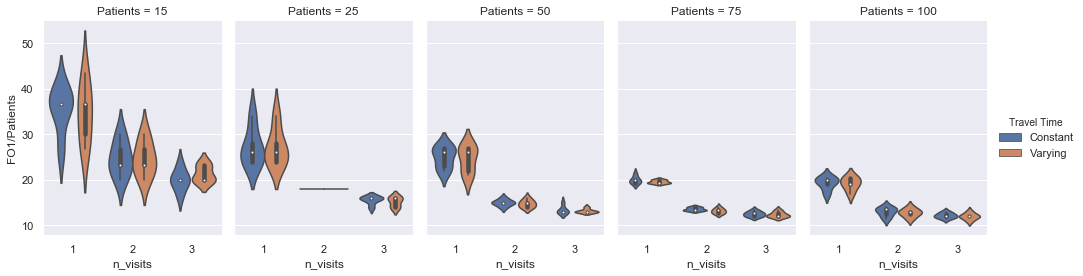

In [164]:
               
g = sns.catplot(x="n_visits", y='FO1/Patients',
                hue="Travel Time", col="Patients",
                data=new[new.nskills==3], kind="violin",
                height=4, aspect=.7);
plt.savefig("MyFig_2.png")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


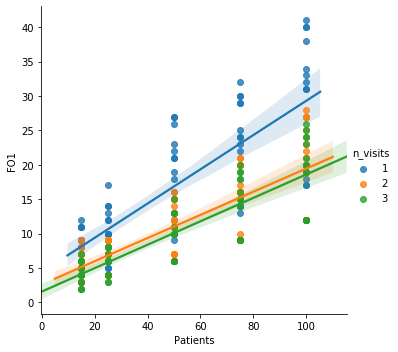

In [67]:
sns.lmplot(x="Patients",y="FO1",hue="n_visits",data=Dimensioning[~df.Constant==False])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


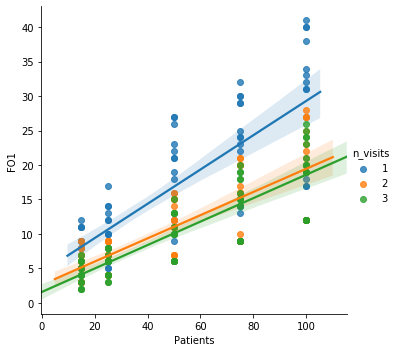

In [68]:
sns.lmplot(x="Patients",y="FO1",hue="n_visits",data=Dimensioning[df.Constant])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


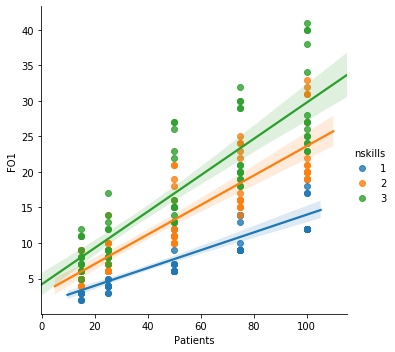

In [70]:
sns.lmplot(x="Patients",y="FO1",hue="nskills",data=Dimensioning[df.Constant])